# Tutorial using expert mode

Here we demonstrate avoiding the use of the disk at all; keeping all objects in memory. It is recommended to at least use the `hdf_file` option of all functions to save the data to disk, just in case!

We will do the same calculations as done in the recipe tutorial, but using the expert API.

You may wish to follow this if:

1. The calculations are inexpensive and can be done in a single process, or filesystem access is very expensive.
2. You wish to use either a non-standard wave function or use a custom accumulator.

Note that the low-level API can be mixed with the recipes API; in fact, the recipes use the low-level API here under the hood, so they are also good references; check `recipes.py`.


In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import gto, scf
import pyqmc.api as pyq
import h5py
import matplotlib.pyplot as plt
from ase.data.pubchem import pubchem_atoms_search
import pyscf.pbc.tools.pyscf_ase as pyscf_ase


/opt/homebrew/Caskroom/miniforge/base/envs/python3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
atoms =  pubchem_atoms_search(name='water')
mol = gto.M(
    atom=pyscf_ase.ase_atoms_to_pyscf(atoms),
    basis="ccECP_cc-pVDZ", ecp="ccecp",
)
mf = scf.RHF(mol)
mf.kernel()


converged SCF energy = -16.9321257267691


-16.932125726769126

Construct the trial wave function. We control which parameters to optimize using a dictionary `to_opt`. Since the cusp conditions are already set for the exact conditions, we do not wish to optimize those parameters. 

Here is where you can insert other wave function objects, a more complex Jastrow, etc.


In [3]:
wf = pyq.MultiplyWF(
    pyq.Slater(mol, mf),
    pyq.generate_jastrow(mol)[0]
)
print(list(wf.parameters.keys()))
print("electron-electron parameters:\n", wf.parameters['wf2bcoeff'])
to_opt = {k:np.ones_like(wf.parameters[k],dtype=bool) for k in ['wf2acoeff','wf2bcoeff']}
to_opt['wf2bcoeff'][0,:] = False
print("parameters to optimize\n", to_opt['wf2bcoeff'])


['wf1det_coeff', 'wf1mo_coeff_alpha', 'wf1mo_coeff_beta', 'wf2bcoeff', 'wf2acoeff']
electron-electron parameters:
 [[-0.25 -0.5  -0.25]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]
parameters to optimize
 [[False False False]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]


The gradient accumulator object presents only the parameters available in to_opt to the optimizer. This can be replaced by any object that presents the same interface, including a custom one that you define yourself. See `LinearTransform` and `PGradTransform` in `accumulators.py`.

In [4]:
nconfig=400
coords = pyq.initial_guess(mol, nconfig)
gradient_accumulator = pyq.gradient_generator(mol, wf, to_opt)
wf, minimization_results = pyq.line_minimization(wf, coords, gradient_accumulator, max_iterations=10)

In [5]:
for r in minimization_results:
    print(r['energy'])
print(wf.parameters['wf2bcoeff'])

-16.99419791016134
-17.109371802877092
-17.131586001398762
-17.151584798575904
-17.166627220956933
-17.17266706469024
-17.173110504534208
-17.176354456482365
-17.17167911623273
-17.177799072725385
[[-0.25       -0.5        -0.25      ]
 [ 0.01640548 -0.00527065  0.01573901]
 [-0.17070071 -0.27458873 -0.17282158]
 [-0.11646714 -0.1173134  -0.11980396]]


The VMC and DMC functions accept a dictionary of accumulator objects. These can be custom defined by the user as well, see `accumulators.py` or the example in `Snippets`.

In [6]:
vmc_data, coords = pyq.vmc(wf, coords, accumulators={'energy':pyq.EnergyAccumulator(mol)})

In [7]:
import scipy.stats
en = vmc_data['energytotal'][1:]
print("average", np.mean(en))
print("standard error", scipy.stats.sem(en))

average -17.174165784834877
standard error 0.0059391103748076485


In [9]:
dmc_data, coords, weights = pyq.rundmc(wf, coords, tstep=0.1, accumulators={'energy':pyq.EnergyAccumulator(mol)})

/opt/homebrew/Caskroom/miniforge/base/envs/python3.9/lib/python3.9/site-packages/pyqmc/slater.py:291: RuntimeWarning: invalid value encountered in true_divide
  return gpu.asnumpy(ratios[1:] / ratios[0])


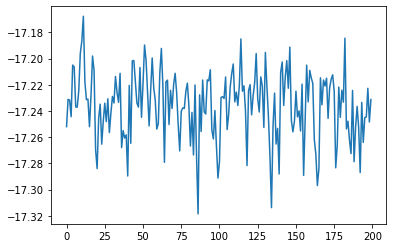

In [11]:
plt.plot(dmc_data['energytotal'])